<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/swinir_with_cropped_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.11.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.9 MB/s eta 0:00:00


In [56]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive
import os

SUBJECT = 'subject9' # @param {type : "string"}

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
DIR_PATH = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_uncompressed_test' # @param {type: "string"}
filepath = os.path.join(DIR_PATH, SUBJECT)
filepath = os.path.join(filepath, 'vid.mp4')

!ls -l $filepath

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-rw------- 1 root root 274835042 Mar 11 03:58 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_uncompressed_test/subject9/vid.mp4


In [3]:
video = media.read_video(filepath)
videos = {'Original': video[:10]}
media.show_videos(videos, fps=30)

In [13]:
# Compress the video with default settings (H.264 codec)
BIT_RATE = "500_000" # @param {type : "string"}
COMPRESSION_BIT_RATES = {BIT_RATE}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))
# Save the compressed video to a file
with open('/tmp/subject1_{BIT_RATE}.mp4', 'wb') as f:
    f.write(compressed_data[BIT_RATE])
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_{BIT_RATE}.mp4')
videos = {'Original': video[:10],  'Compressed_{BIT_RATE}': compressed_video[:10]}
media.show_videos(videos, fps=30)

4222308


In [10]:
## Preprocessing - face detection
import cv2
import datetime
import math
from cv2 import dnn_superres


def read_video(video_file):
    """Reads a video file, returns frames(T, H, W, 3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
      frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      frame = np.asarray(frame)
      frames.append(frame)
      success, frame = VidObj.read()
    return np.asarray(frames)

def face_detection(frame, backend, use_larger_box=False, larger_box_coef=1.0):
        """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            backend(str): backend to utilize for face detection.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bouding box.
        """
        if backend == "HC":
            # Use OpenCV's Haar Cascade algorithm implementation for face detection
            # This should only utilize the CPU
            detector = cv2.CascadeClassifier(
            '/content/drive/MyDrive/DATASETS/haarcascade_frontalface_default.xml')

            # Computed face_zone(s) are in the form [x_coord, y_coord, width, height]
            # (x,y) corresponds to the top-left corner of the zone to define using
            # the computed width and height.
            face_zone = detector.detectMultiScale(frame)

            if len(face_zone) < 1:
                print("ERROR: No Face Detected")
                face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
            elif len(face_zone) >= 2:
                # Find the index of the largest face zone
                # The face zones are boxes, so the width and height are the same
                max_width_index = np.argmax(face_zone[:, 2])  # Index of maximum width
                face_box_coor = face_zone[max_width_index]
                print("Warning: More than one faces are detected. Only cropping the biggest one.")
            else:
                face_box_coor = face_zone[0]
        else:
            raise ValueError("Unsupported face detection backend!")

        if use_larger_box:
            face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
            face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
            face_box_coor[2] = larger_box_coef * face_box_coor[2]
            face_box_coor[3] = larger_box_coef * face_box_coor[3]
        return face_box_coor

2016



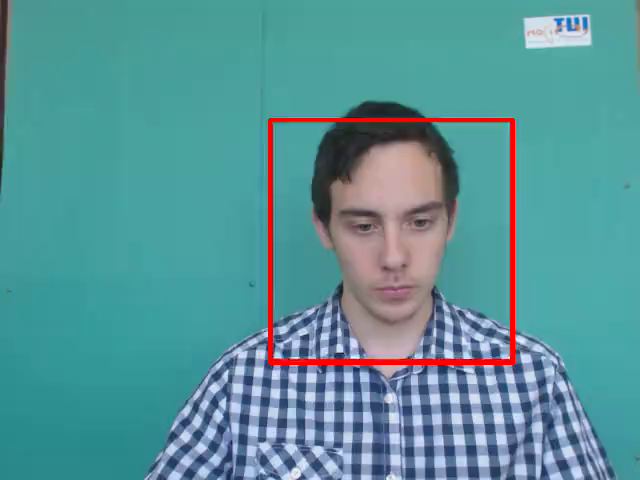

In [15]:
# Check face detection on one frame
print(len(compressed_video))
face_box_coor = face_detection(compressed_video[1], backend='HC', use_larger_box=True, larger_box_coef=1.5)
new_frame = cv2.rectangle(compressed_video[0], (face_box_coor[0], face_box_coor[1]), (face_box_coor[0] + face_box_coor[2], face_box_coor[1] + face_box_coor[3]), (255, 0, 0), 2)
media.show_image(new_frame)

In [16]:
# Download SwinIR pretrained models
!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/trappertwo/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth -P experiments/pretrained_models

rm: cannot remove 'SwinIR': No such file or directory
Cloning into 'SwinIR'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 336 (delta 8), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (336/336), 29.84 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (121/121), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

In [48]:
import numpy as np
import os
import torch
import sys

# Add the SwinIR directory to the system path
sys.path.append('SwinIR')

from models.network_swinir import SwinIR as net

def load_model(model_path):
  """Loads the pretrained SwinIR model
  """
  # set up model
  if os.path.exists(model_path):
    print(f'loading model from {model_path}')
  else:
    raise ValueError(f'model {model_path} does not exist.')
  model = net(upscale=1, in_chans=3, img_size=126, window_size=7,
        img_range=255., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
       mlp_ratio=2, upsampler='', resi_connection='1conv')
  param_key_g = 'params'

  pretrained_model = torch.load(model_path)
  model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)

  return model

def model_inference(img_lq, model, window_size, tile=None, tile_overlap=0):
    if tile is None:
        # test the image as a whole
        output = model(img_lq)
    else:
        # test the image tile by tile
        b, c, h, w = img_lq.size()
        tile = min(tile, h, w)
        assert tile % window_size == 0, "tile size should be a multiple of window_size"
        sf = args.scale

        stride = tile - tile_overlap
        h_idx_list = list(range(0, h-tile, stride)) + [h-tile]
        w_idx_list = list(range(0, w-tile, stride)) + [w-tile]
        E = torch.zeros(b, c, h*sf, w*sf).type_as(img_lq)
        W = torch.zeros_like(E)

        for h_idx in h_idx_list:
            for w_idx in w_idx_list:
                in_patch = img_lq[..., h_idx:h_idx+tile, w_idx:w_idx+tile]
                out_patch = model(in_patch)
                out_patch_mask = torch.ones_like(out_patch)

                E[..., h_idx*sf:(h_idx+tile)*sf, w_idx*sf:(w_idx+tile)*sf].add_(out_patch)
                W[..., h_idx*sf:(h_idx+tile)*sf, w_idx*sf:(w_idx+tile)*sf].add_(out_patch_mask)
        output = E.div_(W)

    return output

def img_restore_swinir(img_lq, model, window_size=7, scale=10):
  """Restore low quality image by remove compresssion artifacts using SwinIR pretrained model.

    Args:
      img_lq: the low quality image
      model: the pretrained SwinIR model
  """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  img_lq = img_lq.astype(np.float32)/ 255
  img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
  img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device)  # CHW-RGB to NCHW-RGB

  # inference
  with torch.no_grad():
    # pad input image to be a multiple of window_size
    _, _, h_old, w_old = img_lq.size()
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
    output = model_inference(img_lq, model, window_size)
    output = output[..., :h_old * scale, :w_old * scale]

    # save image
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    if output.ndim == 3:
      output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # CHW-RGB to HCW-BGR
      output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
      #cv2.imwrite(f'{save_dir}/{imgname}_SwinIR.png', output)

    return output

# Face cropping
def crop_face_resize(frames, use_face_detection,  use_larger_box, larger_box_coef, use_dynamic_detection,
                         detection_freq, use_median_box, width, height,
                     restore=False, model=None):
  """Crop face and resize frames.

     Args:
       frames(np.array): Video frames.
       use_face_detection(bool):  Whether crop the face.
       use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
       detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
       width(int): Target width for resizing.
       height(int): Target height for resizing.
       use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
       larger_box_coef(float): the coefficient of the larger region(height and weight)
                             the middle point of the detected region will stay still during the process of enlarging.
       restore(bool): whether to run compression artifact removal (CAR) to restore compressed video frames.
       model(torch.nn.Module): SwinIR model.
     Returns:
       resized_frames(list[np.array(float)]): Resized and cropped frames
  """
  # Face Cropping
  if use_dynamic_detection:
    num_dynamic_det = math.ceil(frames.shape[0] / detection_freq)
  else:
    num_dynamic_det = 1
  face_region_all = []
  # Perform face detection by num_dynamic_det" times.
  for idx in range(num_dynamic_det):
    if use_face_detection:
       face_region_all.append(face_detection(frames[detection_freq * idx], "HC", use_larger_box, larger_box_coef))
    else:
       face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
  if use_median_box:
     # Generate a median bounding box based on all detected face regions
     face_region_median = np.median(np.asarray(face_region_all, dtype='int'), axis=0).astype('int')
  print(np.asarray(face_region_all, dtype='int'))

  # Frame Resizing
  #resized_frames = np.zeros((frames.shape[0], height, width, 3))
  resized_frames = []
  for i in range(0, frames.shape[0]):
    frame = frames[i]
    if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
      reference_index = i // detection_freq
    else:  # use the first region obtrained from the first frame.
      reference_index = 0
    if use_face_detection:
      if use_median_box:
         face_region = face_region_median
      else:
         face_region = np.asarray(face_region_all, dtype='int')[reference_index]
      frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
         max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]

    # Resize the frame
    resized_frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)

    if restore:
      print("Restoring " + str(i))
      media.show_image(resized_frame)
      resized_frame = img_restore_swinir(resized_frame, model)
      print("After restoration... ")
      media.show_image(resized_frame)

    resized_frames.append(resized_frame)

  return np.array(resized_frames)

def frames_to_video(frames, output_path, fps=30):
    """Converts a sequence of frames to an MPEG4 video.

    Args:
        frames: A list of frames (numpy arrays) to be converted to a video.
        output_path: Name of the output video file (e.g., 'output.mp4').
        fps: Frames per second for the output video.
    """

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MPEG-4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_writer.write(frame_rgb)

    video_writer.release()

In [33]:
MODEL_PATH = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth'
swinir_model = load_model(MODEL_PATH)
print(swinir_model)

loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
SwinIR(
  (conv_first): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=180, input_resolution=(126, 126), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=180, input_resolution=(126, 126), num_heads=6, window_size=7, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=180, window_size=(7, 7), num_heads=6
              (qkv): Linear(in_features=180, out_features=540, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=

[[269 118 246 246]]
[[269 118 246 246]]
Restoring 0



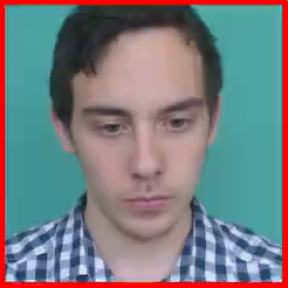

After restoration... 



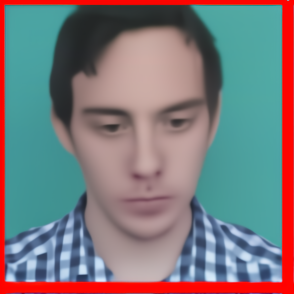

Restoring 1



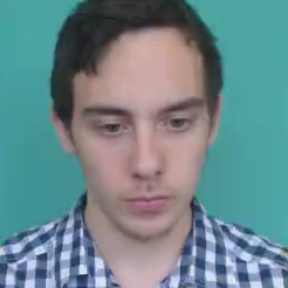

After restoration... 



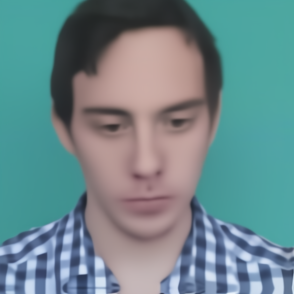

Restoring 2



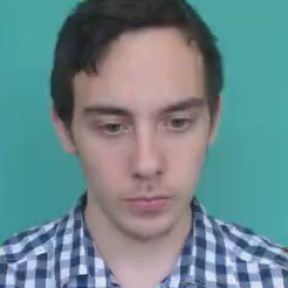

After restoration... 



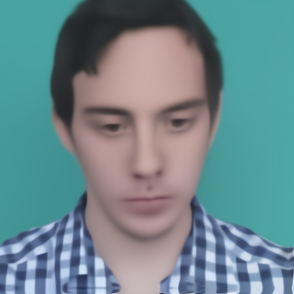

Restoring 3



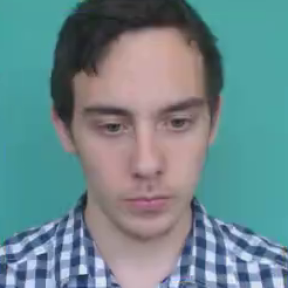

After restoration... 



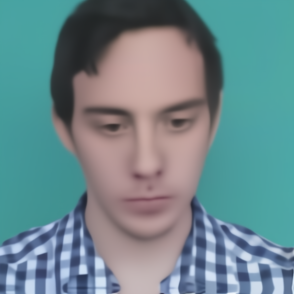

Restoring 4



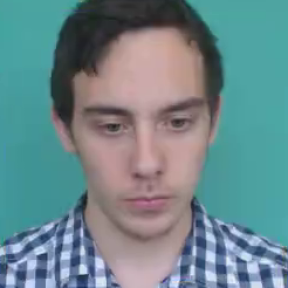

After restoration... 



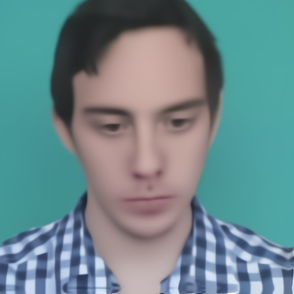

Restoring 5



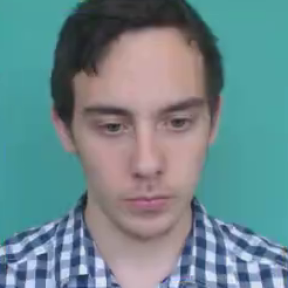

After restoration... 



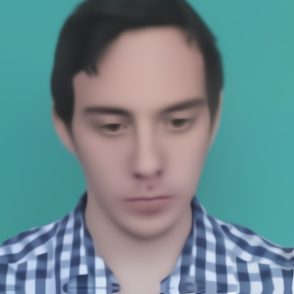

Restoring 6



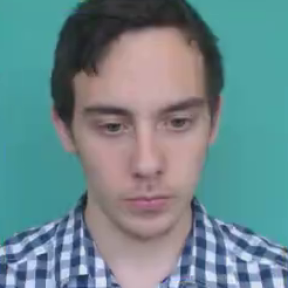

After restoration... 



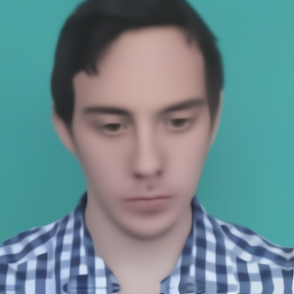

Restoring 7



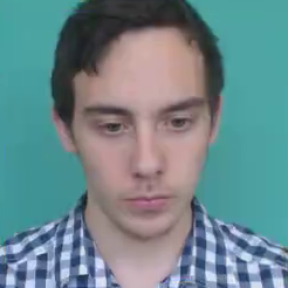

After restoration... 



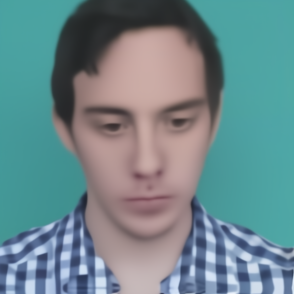

Restoring 8



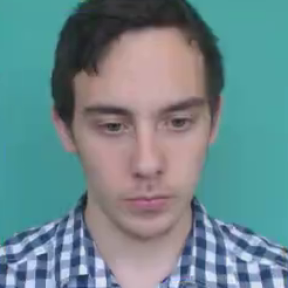

After restoration... 



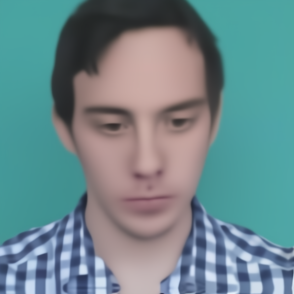

Restoring 9



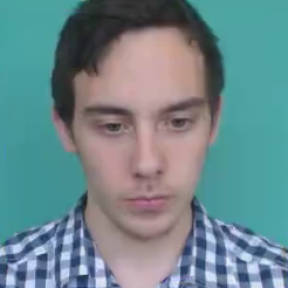

After restoration... 



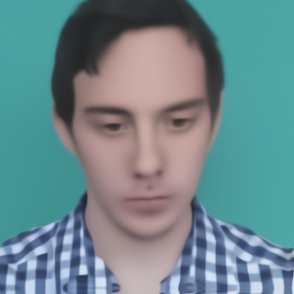

Writing /tmp/subject9/vid1.mp4
Writing /tmp/subject9/vid2.mp4
total 56
-rw-r--r-- 1 root root 17365 Aug  9 20:56 vid1.mp4
-rw-r--r-- 1 root root 22017 Aug  9 20:56 vid2.mp4
-rw-r--r-- 1 root root 10563 Aug  9 20:29 vid.mp4


In [65]:
import os

PREPROCESSED_PATH = '/tmp/' # @param{type: "string"}
path = os.path.join(PREPROCESSED_PATH, SUBJECT)
if not os.path.isdir(path):
  os.mkdir(path)

# Generate preprocessed data by just cropping face, resizing the compressed video
preprocessed_data1 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=288,
                                     height=288)

# Generate preprocessed data by cropping face, resizing and then restoring the
# frame using SwinIR model
preprocessed_data2 = crop_face_resize(compressed_video[:10],
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=288,
                                     height=288,
                                     restore=True,
                                     model=swinir_model)
print("Writing " + os.path.join(PREPROCESSED_PATH, dirname, 'vid1.mp4'))
frames_to_video(preprocessed_data1, os.path.join(PREPROCESSED_PATH, dirname, 'vid1.mp4'))

print("Writing " + os.path.join(PREPROCESSED_PATH, dirname, 'vid2.mp4'))
frames_to_video(preprocessed_data2, os.path.join(PREPROCESSED_PATH, dirname, 'vid2.mp4'))
!ls -l $path

In [66]:
cropped_video1 = media.read_video(os.path.join(PREPROCESSED_PATH, SUBJECT, 'vid1.mp4'))
cropped_video2 = media.read_video(os.path.join(PREPROCESSED_PATH, SUBJECT, 'vid2.mp4'))

videos = {'Without Restoration': cropped_video1, 'With restoration': cropped_video2}
media.show_videos(videos, fps=30)